CIS9760_Project2_Yaheng Wu(Phoebe)

# Analysis of Yelp Business Intelligence Data

Big Idea:<br/>
In this project, I analyzed a subset of the Yelp's business, reviews and user data to answer the following three questions: <br/> 
- Do Yelp Reviews Skew Negative?
- Should the Elite be Trusted?
- What is the Most Recommended Restaurant?

Data Source: <br/>
The three datasets originally come from [Kaggle](https://www.kaggle.com/yelp-dataset/yelp-dataset) and they have been uploaded into an S3 bucket for the use of this project.<br/>
- s3://yelpreviewdataset/yelp_academic_dataset_business.json <br/>
- s3://yelpreviewdataset/yelp_academic_dataset_review.json <br/>
- s3://yelpreviewdataset/yelp_academic_dataset_user.json <br/>

## Part I: Installation and Initial Setup

### 1. Install Packages

In [1]:
from pyspark.sql import SparkSession
my_spark = SparkSession.builder.getOrCreate()
sc.install_pypi_package("pandas==1.0.3")
sc.install_pypi_package("matplotlib==3.2.1")
sc.install_pypi_package("seaborn==0.10.0")
sc.install_pypi_package("wordcloud==1.8.1")
sc.list_packages()

VBox()

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
0,application_1606577942836_0001,pyspark,idle,Link,Link,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…





Package                    Version  
-------------------------- ---------
beautifulsoup4             4.9.1    
boto                       2.49.0   
click                      7.1.2    
cycler                     0.10.0   
jmespath                   0.10.0   
joblib                     0.16.0   
kiwisolver                 1.3.1    
lxml                       4.5.2    
matplotlib                 3.2.1    
mysqlclient                1.4.2    
nltk                       3.5      
nose                       1.3.4    
numpy                      1.16.5   
pandas                     1.0.3    
Pillow                     8.0.1    
pip                        9.0.1    
py-dateutil                2.2      
pyparsing                  2.4.7    
python-dateutil            2.8.1    
python37-sagemaker-pyspark 1.4.0    
pytz                       2020.1   
PyYAML                     5.3.1    
regex                      2020.7.14
scipy                      1.5.4    
seaborn                    0.10.0 

### 2. Importing

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import pyspark.sql.functions as F
from pyspark.sql.functions import explode, split, desc, col, avg, udf, when
from pyspark.sql.types import IntegerType, StringType, DoubleType

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

### 3. Loading Data

In [3]:
business_df = spark.read.json('s3://yelpreviewdataset/yelp_academic_dataset_business.json')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

### 4. Overview of Data

In [4]:
print(f'Columns: {len(business_df.columns)} | Rows: {business_df.count():,}')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Columns: 14 | Rows: 209,393

In [5]:
business_df.printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- address: string (nullable = true)
 |-- attributes: struct (nullable = true)
 |    |-- AcceptsInsurance: string (nullable = true)
 |    |-- AgesAllowed: string (nullable = true)
 |    |-- Alcohol: string (nullable = true)
 |    |-- Ambience: string (nullable = true)
 |    |-- BYOB: string (nullable = true)
 |    |-- BYOBCorkage: string (nullable = true)
 |    |-- BestNights: string (nullable = true)
 |    |-- BikeParking: string (nullable = true)
 |    |-- BusinessAcceptsBitcoin: string (nullable = true)
 |    |-- BusinessAcceptsCreditCards: string (nullable = true)
 |    |-- BusinessParking: string (nullable = true)
 |    |-- ByAppointmentOnly: string (nullable = true)
 |    |-- Caters: string (nullable = true)
 |    |-- CoatCheck: string (nullable = true)
 |    |-- Corkage: string (nullable = true)
 |    |-- DietaryRestrictions: string (nullable = true)
 |    |-- DogsAllowed: string (nullable = true)
 |    |-- DriveThru: string (nullable = true)
 |    |-- GoodForDancing: str

Display the first 5 rows with the following columns:

- business_id
- name
- city
- state
- categories

In [6]:
busi_df = business_df.select('business_id', 'name', 'city', 'state', 'stars', 'categories')
busi_df.show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+--------------------+---------------+-----+-----+--------------------+
|         business_id|                name|           city|state|stars|          categories|
+--------------------+--------------------+---------------+-----+-----+--------------------+
|f9NumwFMBDn751xgF...|The Range At Lake...|      Cornelius|   NC|  3.5|Active Life, Gun/...|
|Yzvjg0SayhoZgCljU...|   Carlos Santo, NMD|     Scottsdale|   AZ|  5.0|Health & Medical,...|
|XNoUzKckATkOD1hP6...|             Felinus|       Montreal|   QC|  5.0|Pets, Pet Service...|
|6OAZjbxqM5ol29BuH...|Nevada House of Hose|North Las Vegas|   NV|  2.5|Hardware Stores, ...|
|51M2Kk903DFYI6gnB...|USE MY GUY SERVIC...|           Mesa|   AZ|  4.5|Home Services, Pl...|
+--------------------+--------------------+---------------+-----+-----+--------------------+
only showing top 5 rows

## Part II: Analyzing Categories

Let's now answer: **How many unique categories are represented in this dataset?**

Essentially, we have the categories per business as a list - this is useful to quickly see what each business might be represented as but it is difficult to easily answer the following questions such as:

- How many businesses are categorized as Active Life？
- What are the top 20 most popular categories available?

### 1. Association Table 
We need to "break out" these categories from the business ids? One common approach to take is to build an association table mapping a single business id multiple times to each distinct category.

For instance, given the following:

| business_id |	categories |
|:------------|:-----------|
| abcd123     | a,b,c      |


We would like to derive something like:

| business_id |	category |
|:------------|:---------|
| abcd123     | a        |
| abcd123	  | b        |
| abcd123	  | c        |


What this does is allow us to then perform a myriad of rollups and other analysis on this association table which can aid us in answering the questions asked above.

Display the first 5 rows of the association table below

In [7]:
associ_table_one = business_df.select('business_id', explode(split(business_df.categories, ', ')).alias('category'))
associ_table_one.show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+----------------+
|         business_id|        category|
+--------------------+----------------+
|f9NumwFMBDn751xgF...|     Active Life|
|f9NumwFMBDn751xgF...|Gun/Rifle Ranges|
|f9NumwFMBDn751xgF...|     Guns & Ammo|
|f9NumwFMBDn751xgF...|        Shopping|
|Yzvjg0SayhoZgCljU...|Health & Medical|
+--------------------+----------------+
only showing top 5 rows

### 2. Total Unique Categories

Finally, we are ready to answer the question: **what is the total number of unique categories available?**

In [8]:
associ_table_one.select('category').distinct().count()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

1336

### 3. Top Categories By Business
Now let's find the top categories in this dataset by rolling up categories.
#### Counts of Businesses / Category

In [9]:
category_count = associ_table_one.select('category').groupby(associ_table_one.category).count()
category_count.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+-----+
|            category|count|
+--------------------+-----+
|      Dermatologists|  341|
|      Paddleboarding|   36|
|        Aerial Tours|   28|
|         Hobby Shops|  828|
|          Bubble Tea|  720|
|             Embassy|   13|
|            Handyman|  682|
|             Tanning|  938|
|      Aerial Fitness|   29|
|             Tempura|    1|
|             Falafel|  159|
|       Outlet Stores|  399|
|        Summer Camps|  318|
|     Clothing Rental|   55|
|      Sporting Goods| 2311|
|     Cooking Schools|  118|
|  College Counseling|   15|
|  Lactation Services|   50|
|Ski & Snowboard S...|   50|
|             Museums|  359|
+--------------------+-----+
only showing top 20 rows

#### Bar Chart of Top Categories
With this data available, let us now build a barchart of the top 20 categories

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

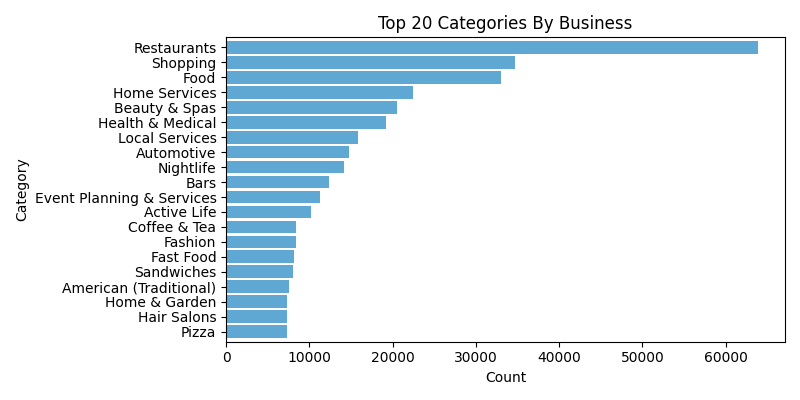

In [10]:
top_20 = category_count.sort(desc('count')).limit(20).toPandas()

ax = top_20.plot(kind='barh', x='category', y='count', 
            figsize=(8, 4), color='#5fa8d3', zorder=2, width=0.85)

ax.invert_yaxis()
ax.set_xlabel("Count")
ax.set_ylabel("Category")
ax.set_title("Top 20 Categories By Business")
ax.get_legend().remove()

plt.tight_layout()
%matplot plt

Clears the entire current figure with all its axes

In [11]:
plt.clf()
plt.cla()
plt.close()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## Part III. Do Yelp Reviews Skew Negative?
Oftentimes, it is said that the only people who write a written review are those who are extremely dissatisfied or extremely satisfied with the service received.

How true is this really? Let's try and answer this question.

### 1. Loading Review Data

Begin by loading the review data set from S3 and printing schema to determine what data is available

In [12]:
review_df = spark.read.json('s3://yelpreviewdataset/yelp_academic_dataset_review.json')
review_df.printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- business_id: string (nullable = true)
 |-- cool: long (nullable = true)
 |-- date: string (nullable = true)
 |-- funny: long (nullable = true)
 |-- review_id: string (nullable = true)
 |-- stars: double (nullable = true)
 |-- text: string (nullable = true)
 |-- useful: long (nullable = true)
 |-- user_id: string (nullable = true)

Let's begin by listing the business_id and stars columns together for the user reviews data

In [13]:
business_stars = review_df.select('business_id', 'stars')
business_stars.show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+-----+
|         business_id|stars|
+--------------------+-----+
|-MhfebM0QIsKt87iD...|  2.0|
|lbrU8StCq3yDfr-QM...|  1.0|
|HQl28KMwrEKHqhFrr...|  5.0|
|5JxlZaqCnk1MnbgRi...|  1.0|
|IS4cv902ykd8wj1TR...|  4.0|
+--------------------+-----+
only showing top 5 rows

Now, let's aggregate along the stars column to get a resultant dataframe that displays average stars per business as accumulated by users who **took the time to submit a written review**

In [14]:
written_review = review_df.where(col("text").isNotNull()).groupby(review_df.business_id).agg(avg(col("stars")))
written_review.show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+------------------+
|         business_id|        avg(stars)|
+--------------------+------------------+
|VHsNB3pdGVcRgs6C3...| 3.411764705882353|
|RMjCnixEY5i12Ciqn...|3.5316455696202533|
|ipFreSFhjClfNETuM...|               2.6|
|dLDMU8bOLnkDTmPUr...| 4.942857142857143|
|Qm2datcYBPXrPATVG...| 4.352941176470588|
+--------------------+------------------+
only showing top 5 rows

Now the fun part - let's join our two dataframes (reviews and business data) by business_id

In [15]:
user_review = review_df.groupby(review_df.business_id).agg(avg(col("stars")))
# inner join
joined_written_review = business_df.join(written_review, on=['business_id'])
joined_user_review = business_df.join(user_review,on=['business_id'])

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Let's see a few of these:

In [16]:
joined_written_review.select("""avg(stars)""","stars","name","city","state").sort(desc("""avg(stars)""")).show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----------+-----+--------------------+----------+-----+
|avg(stars)|stars|                name|      city|state|
+----------+-----+--------------------+----------+-----+
|       5.0|  5.0| KNG Marketing Group|     Tempe|   AZ|
|       5.0|  5.0|Eagle Ridge Painting|  Chandler|   AZ|
|       5.0|  5.0|       MAC Cosmetics|Pittsburgh|   PA|
|       5.0|  5.0| Hernandez Ironworks|   Phoenix|   AZ|
|       5.0|  5.0|Edward J Malik, O...| Las Vegas|   NV|
+----------+-----+--------------------+----------+-----+
only showing top 5 rows

Compute a new dataframe that calculates what we will call the skew (for lack of a better word) between the avg stars accumulated from written reviews and the actual star rating of a business (ie: the average of stars given by reviewers who wrote an actual review and reviewers who just provided a star rating).

The formula you can use is something like:

(row['avg(stars)'] - row['stars']) / row['stars']

If the **skew** is negative, we can interpret that to be: reviewers who left a written response were more dissatisfied than normal. If **skew** is positive, we can interpret that to be: reviewers who left a written response were more satisfied than normal.

In [17]:
fv_joined_written_review = joined_written_review.select("avg(stars)","stars","name","city","state") \
                                                .sort("""avg(stars)""",ascending=False)

fv_joined_user_review = joined_user_review.select("avg(stars)","stars","name","city","state") \
                                            .sort("""avg(stars)""",ascending=False)

fv_df = fv_joined_written_review.withColumn("skew", 
                                            ((fv_joined_written_review["""avg(stars)"""]-fv_joined_user_review["stars"]) \
                                             /fv_joined_written_review["stars"]))

fv_df.sort("""skew""",ascending=False).show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+------------------+-----+--------------------+-----------+-----+------------------+
|        avg(stars)|stars|                name|       city|state|              skew|
+------------------+-----+--------------------+-----------+-----+------------------+
|2.3333333333333335|  1.0| Mikado Sushi Robata|    Toronto|   ON|1.3333333333333335|
|3.3333333333333335|  1.5|Black Brook Golf ...|     Mentor|   OH|1.2222222222222223|
|               2.0|  1.0|DollarPlus Discou...|  Las Vegas|   NV|               1.0|
|               2.0|  1.0|Torrey Pines Reha...|  Las Vegas|   NV|               1.0|
|               2.0|  1.0|Golden West Pool ...|  Las Vegas|   NV|               1.0|
|               2.0|  1.0|           H&R Block|    Calgary|   AB|               1.0|
|               2.0|  1.0|Convenient Food M...|     Elyria|   OH|               1.0|
|               2.0|  1.0|Foothills Primary...|   Chandler|   AZ|               1.0|
|               2.0|  1.0|Affordable Decks ...|Bethel Park|   PA|

In [18]:
fv_df = fv_df.toPandas()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

And finally, graph it!

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

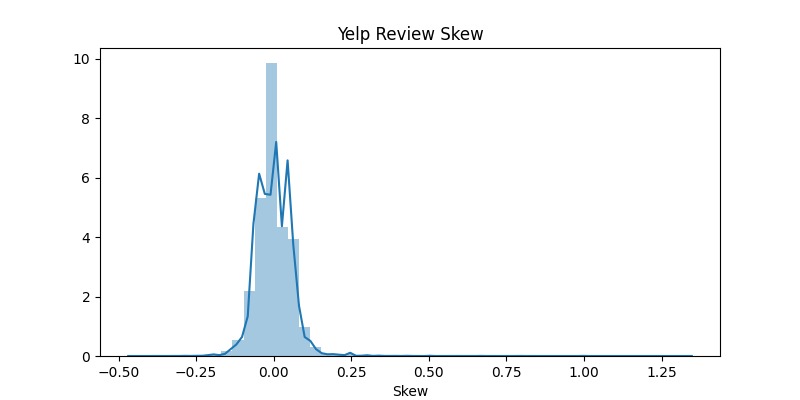

In [19]:
plt.figure(figsize=(8,4))
ax = sns.distplot(fv_df["skew"])
ax.set_xlabel('Skew')
plt.title("Yelp Review Skew")

%matplot plt

Clears the entire current figure with all its axes

In [20]:
plt.clf()
plt.cla()
plt.close()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

So, do Yelp (written) Reviews skew negative? Does this analysis actually prove anything? Expound on implications / interpretations of this graph.

The distribution of skew appears to be normal, but skewed a little bit to the right. The implications of the above graph are that the satisfaction level of reviewers who left positively skewed reviews is greater than the dissatisfaction level of reviewers who left negatively skewed reviews. In other words, reviewers who left a written response were slightly more satisfied than normal.

## Part IV. Should the Elite be Trusted? 
How accurate or close are the ratings of an "elite" user (check Users table schema) vs the actual business rating

It takes a special Yelper to become an Elite. Frequent, quality reviews and photos are important in the application of the elite status on Yelp. Elite candidates need to meet the criteria below for the consideration. 

To become Elite, Yelpers agree that they

- Are using their real name on Yelp.
- Have a clear photo of themself on their profile page.
- Are of legal drinking age where they live.

They also agree that they are NOT
- A business owner.
- Closely affiliated with a business owner. 
- Managing a Yelp Business Account.
- Working for one of Yelp's competitors.

It's important to know that accepting compensation or freebies in exchange for reviews or leveraging the Elite Squad for personal or commercial gain will result in Elite status being revoked or account closure.

### 1. Loading User Data

In [21]:
user_df = spark.read.json('s3://yelpreviewdataset/yelp_academic_dataset_user.json')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

### 2. Overview of Data

In [22]:
user_df.printSchema()
print(f'User Dataset Columns: {len(user_df.columns)} | Rows: {user_df.count():,}')
review_df.printSchema()
print(f'Review Dataset Columns: {len(review_df.columns)} | Rows: {review_df.count():,}')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- average_stars: double (nullable = true)
 |-- compliment_cool: long (nullable = true)
 |-- compliment_cute: long (nullable = true)
 |-- compliment_funny: long (nullable = true)
 |-- compliment_hot: long (nullable = true)
 |-- compliment_list: long (nullable = true)
 |-- compliment_more: long (nullable = true)
 |-- compliment_note: long (nullable = true)
 |-- compliment_photos: long (nullable = true)
 |-- compliment_plain: long (nullable = true)
 |-- compliment_profile: long (nullable = true)
 |-- compliment_writer: long (nullable = true)
 |-- cool: long (nullable = true)
 |-- elite: string (nullable = true)
 |-- fans: long (nullable = true)
 |-- friends: string (nullable = true)
 |-- funny: long (nullable = true)
 |-- name: string (nullable = true)
 |-- review_count: long (nullable = true)
 |-- useful: long (nullable = true)
 |-- user_id: string (nullable = true)
 |-- yelping_since: string (nullable = true)

User Dataset Columns: 22 | Rows: 1,968,703
root
 |-- business_id: str

In [23]:
user_df.select('user_id','elite').show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+--------------------+
|             user_id|               elite|
+--------------------+--------------------+
|ntlvfPzc8eglqvk92...|                    |
|FOBRPlBHa3WPHFB5q...|2008,2009,2010,20...|
|zZUnPeh2hEp0WydbA...|                2010|
|QaELAmRcDc5TfJEyl...|                2009|
|xvu8G900tezTzbbfq...|2009,2010,2011,20...|
+--------------------+--------------------+
only showing top 5 rows

### 3. Split Elite column

In [24]:
user_elite_split = user_df.select('user_id', explode(split(user_df.elite, ',')).alias('elite'))
user_elite_split = user_elite_split.withColumn('elite', user_elite_split.elite.cast(IntegerType()))
user_elite_split.show(5)
print(f'User Elite Split Dataset Columns: {len(user_elite_split.columns)} | Rows: {user_elite_split.count():,}')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+-----+
|             user_id|elite|
+--------------------+-----+
|ntlvfPzc8eglqvk92...| null|
|FOBRPlBHa3WPHFB5q...| 2008|
|FOBRPlBHa3WPHFB5q...| 2009|
|FOBRPlBHa3WPHFB5q...| 2010|
|FOBRPlBHa3WPHFB5q...| 2011|
+--------------------+-----+
only showing top 5 rows

User Elite Split Dataset Columns: 2 | Rows: 2,125,315

In [25]:
user_elite_split.select("elite").distinct().sort('elite', ascending=False).show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----+
|elite|
+-----+
| 2018|
| 2017|
| 2016|
| 2015|
| 2014|
| 2013|
| 2012|
| 2011|
| 2010|
| 2009|
| 2008|
| 2007|
| 2006|
| null|
+-----+

In [26]:
Elite_or_Not = user_elite_split.select('user_id',
           when(user_elite_split.elite.isNull(), "Not Elite").otherwise("Elite").alias('Elite or Not'))
Elite_or_Not.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+------------+
|             user_id|Elite or Not|
+--------------------+------------+
|ntlvfPzc8eglqvk92...|   Not Elite|
|FOBRPlBHa3WPHFB5q...|       Elite|
|FOBRPlBHa3WPHFB5q...|       Elite|
|FOBRPlBHa3WPHFB5q...|       Elite|
|FOBRPlBHa3WPHFB5q...|       Elite|
|FOBRPlBHa3WPHFB5q...|       Elite|
|FOBRPlBHa3WPHFB5q...|       Elite|
|zZUnPeh2hEp0WydbA...|       Elite|
|QaELAmRcDc5TfJEyl...|       Elite|
|xvu8G900tezTzbbfq...|       Elite|
|xvu8G900tezTzbbfq...|       Elite|
|xvu8G900tezTzbbfq...|       Elite|
|xvu8G900tezTzbbfq...|       Elite|
|xvu8G900tezTzbbfq...|       Elite|
|xvu8G900tezTzbbfq...|       Elite|
|xvu8G900tezTzbbfq...|       Elite|
|xvu8G900tezTzbbfq...|       Elite|
|xvu8G900tezTzbbfq...|       Elite|
|z5_82komKV3mI4ASG...|       Elite|
|ttumcu6hWshk_EJVW...|   Not Elite|
+--------------------+------------+
only showing top 20 rows

In [27]:
unique_user_df = Elite_or_Not.dropDuplicates(['user_id'])
unique_user_df.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+------------+
|             user_id|Elite or Not|
+--------------------+------------+
|---RfKzBwQ8t3wu-L...|   Not Elite|
|--1UpCuUDJQbqiuFX...|   Not Elite|
|--AGAPpP1pgp1afbq...|   Not Elite|
|--C-42rr7hPSsUROJ...|   Not Elite|
|--ChzqcPs4YFWlw1j...|   Not Elite|
|--ET3paBtrThD95dk...|   Not Elite|
|--GLTFzU93A40YB56...|   Not Elite|
|--I4wRDhmM2J2VLzK...|   Not Elite|
|--RquisWmBzcezXZr...|   Not Elite|
|--UizzbnQlZg7bEv2...|   Not Elite|
|--cd_gA-9Q8gM9P2c...|   Not Elite|
|--dhSVoOFDBiMCCwD...|   Not Elite|
|--fpTdHQOGWGbAjk9...|   Not Elite|
|--ju6XpRd0dY1Swmf...|   Not Elite|
|--oVdTxVd7QVr8Y0U...|   Not Elite|
|--pWqE-KOwDWo5ADG...|   Not Elite|
|--t6W1JHbStaCp5RO...|   Not Elite|
|--tmwndDOZJwfRvvt...|   Not Elite|
|--yrdC1dIR6VYsW6k...|   Not Elite|
|-06viLTmtlRTHxxDg...|   Not Elite|
+--------------------+------------+
only showing top 20 rows

Plot Yelpers by their status

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

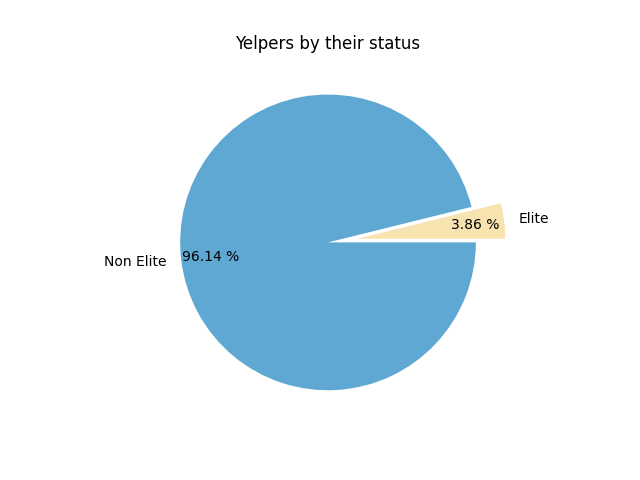

In [60]:
eliteCount = unique_user_df.select("Elite or Not").filter(col("Elite or Not") == "Elite").count()
noneliteCount = unique_user_df.select("Elite or Not").filter(col("Elite or Not") == "Not Elite").count()
labels = ["Elite", "Non Elite"]
colors = ["#f7e3af", "#5fa8d3"]
explode = (0.2, 0)  
plt.pie([eliteCount,noneliteCount], labels = labels, colors = colors, autopct="%.2f %%", pctdistance=0.8, explode=explode)
plt.title("Yelpers by their status")
plt.show()

%matplot plt

As we can see from the pie chart above, around 96.14% of Yelpers are non elite, whereas only 3.86% of Yelpers are elite.

Clears the entire current figure with all its axes

In [73]:
plt.clf()
plt.cla()
plt.close()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

### 4. Join "Unique User" Dataset with Review Dataset

In [28]:
user_join_review = review_df.join(unique_user_df, on = "user_id", how='left')
print(f'User Join Review Dataset Columns: {len(user_join_review.columns)} | Rows: {user_join_review.count():,}')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

User Join Review Dataset Columns: 10 | Rows: 8,021,122

### 5. Clean Data

Combined Dateset which includes elite and non-elite

In [29]:
combine_df = user_join_review.select('review_id','business_id','stars','user_id','Elite or Not')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Combined (Elite and Non-Elite) Average Ratings Grouped by Business ID

In [30]:
combine_stars_df = combine_df.groupBy("business_id").agg(F.mean('stars').alias('Stars'))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Elite Only Dataset

In [31]:
elite_df = combine_df.filter(col("Elite or Not") == "Elite")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Elite Average Rating Grouped by Business ID

In [32]:
elite_stars_df = elite_df.groupBy("business_id").agg(F.mean('stars').alias('Stars rated by elite'))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Non-Elite Dataset

In [33]:
non_elite_df = combine_df.filter(col("Elite or Not") == "Not Elite")  

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Non-Elite Average Rating Grouped by Business ID

In [34]:
non_elite_stars_df = non_elite_df.groupBy("business_id").agg(F.mean('stars').alias('Stars rated by non elite'))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Prepare data for plotting

In [62]:
combined_data = combine_stars_df.toPandas()["Stars"].values.tolist()
elite_data = elite_stars_df.toPandas()["Stars rated by elite"].values.tolist()
non_elite_data = non_elite_stars_df.toPandas()["Stars rated by non elite"].values.tolist()
data = [combined_data, elite_data, non_elite_data]

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

And finally, graph it!

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

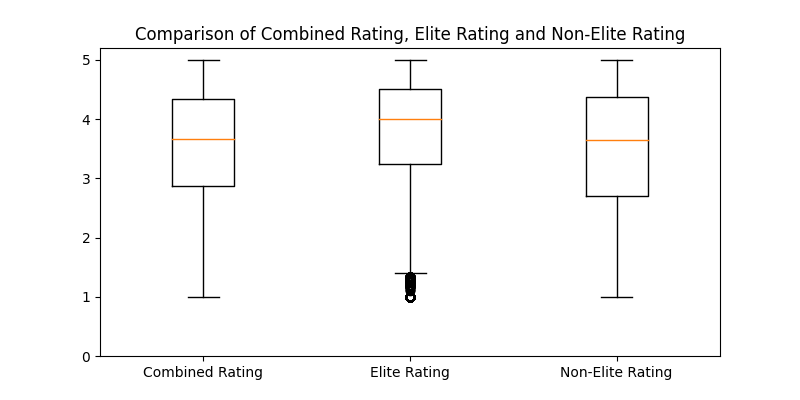

In [36]:
fig = plt.figure(figsize =(8, 4)) 
plt.boxplot(data)
plt.xticks([1, 2, 3], ['Combined Rating', 'Elite Rating', 'Non-Elite Rating'])
plt.title("Comparison of Combined Rating, Elite Rating and Non-Elite Rating")
y_ticks = np.arange(0, 6, 1)
plt.yticks(y_ticks)
%matplot plt

Clears the entire current figure with all its axes

In [61]:
plt.clf()
plt.cla()
plt.close()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

As we can see from the boxplot, the first, third quantiles, and the median of the elite ratings are higher than the non-elites' ratings. In addition, most low ratings in elite dataset are being categoried as outliers. Overall, I would say elite should not be trusted because they tend to give higher ratings compared with non-elite group.

## Part V. What is the Most Recommended Restaurant?

### 1. Filter business data to collect 5 star rated restaurants

In [38]:
five_strs_resta_df = business_df.select('business_id', 'name', 'city', 'stars', 'review_count', 'address', 'categories') \
                                        .where(col('categories').like("%Restaurants%")) \
                                        .filter(col("stars") == 5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

### 2. Check which city has the largest number of 5 star rated restaurants

In [39]:
city_count = five_strs_resta_df.select('city').groupby(five_strs_resta_df.city).count().sort('count', ascending=False)
city_count.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----------+-----+
|       city|count|
+-----------+-----+
|  Las Vegas|  225|
|   Montréal|  171|
|    Toronto|  165|
|    Phoenix|  132|
| Pittsburgh|   82|
|    Calgary|   79|
|  Cleveland|   61|
|  Charlotte|   55|
| Scottsdale|   43|
|       Mesa|   36|
|    Madison|   34|
|Mississauga|   27|
|  Henderson|   22|
|      Tempe|   19|
|   Chandler|   18|
|    Gilbert|   18|
|   Glendale|   16|
|      Laval|   15|
|   Brampton|   13|
|   Matthews|    9|
+-----------+-----+
only showing top 20 rows

### 3. Plot the top 10 cities that have the largest number of 5 star rated restaurants

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

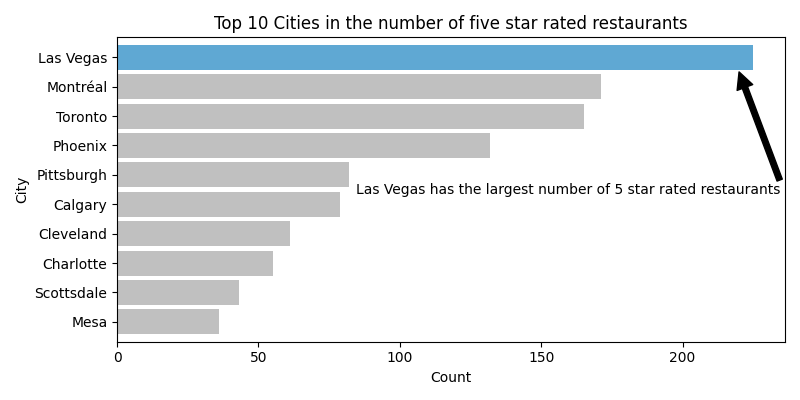

In [40]:
top_10 = city_count.sort(desc('count')).limit(10).toPandas()

ax = top_10.plot(kind='barh', x='city', y='count', 
            figsize=(8, 4), zorder=2, width=0.85, \
                 color=['#5fa8d3','silver','silver','silver','silver','silver','silver','silver','silver','silver'])

ax.invert_yaxis()
ax.set_xlabel("Count")
ax.set_ylabel("City")
ax.set_title("Top 10 Cities in the number of five star rated restaurants")
ax.annotate('Las Vegas has the largest number of 5 star rated restaurants',
            xy=(220, 0.5), xycoords='data',
            xytext=(30, -90), textcoords='offset points',
            arrowprops=dict(facecolor='black'),
            horizontalalignment='right', verticalalignment='bottom')
ax.get_legend().remove() 

plt.tight_layout()
%matplot plt

Clears the entire current figure with all its axes

In [41]:
plt.clf()
plt.cla()
plt.close()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

### 4. Deep dive into Las Vegas and check which restaurants has the most reviews

In [42]:
Las_Vegas_five_strs_resta = five_strs_resta_df.filter(col("city") == "Las Vegas")  
Las_Vegas_top_10_most_reviews_resta = Las_Vegas_five_strs_resta.select('business_id','name', 'categories', 'review_count') \
                                                                .sort("""review_count""",ascending=False).limit(10)
Las_Vegas_top_10_most_reviews_resta.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+--------------------+--------------------+------------+
|         business_id|                name|          categories|review_count|
+--------------------+--------------------+--------------------+------------+
|IhNASEZ3XnBHmuuVn...|        Brew Tea Bar|Restaurants, Food...|        1827|
|8fFTJBh0RB2EKG53i...|      Zenaida's Cafe|Cafes, Breakfast ...|         717|
|G4hjhtA_wQ-tSOGpg...|Bajamar Seafood &...|Fast Food, Dive B...|         658|
|cePE3rCuUOVSCCAHS...|              Karved|Restaurants, Sand...|         651|
|3pSUr_cdrphurO6m1...|       J Karaoke Bar|Nightlife, Bars, ...|         534|
|2B46bRpDh49eDyjXG...| La Maison de Maggie|Cafes, Creperies,...|         397|
|kafUXRNfQm3e_U14S...|      Pizzeria Monzú|Italian, Pizza, B...|         381|
|4Pl-ziYL2oerGyIPl...|Chuchote Thai Bis...|Comfort Food, Res...|         370|
|O7UMzd3i-Zk8dMeyY...|      Art of Flavors|American (New), I...|         345|
|sVjL9DQ8hYW_pS-jp...|Water Grill - Las...|Restaurants, Seafood|

### 5. Plot the top 10 five-star rated restaurants at Las Vegas in the number of reviews

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

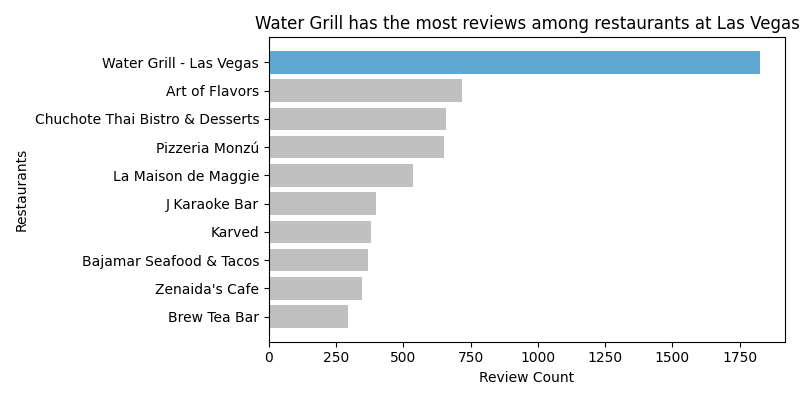

In [72]:
fig = plt.figure(figsize =(8, 4))
restaurants_name = Las_Vegas_top_10_most_reviews_resta.toPandas()["name"].values.tolist()
review_count = Las_Vegas_top_10_most_reviews_resta.sort('review_count').toPandas()["review_count"].values.tolist()
plt.barh(restaurants_name, review_count, color=['silver','silver','silver','silver','silver','silver','silver','silver','silver','#5fa8d3'])
plt.xlabel("Review Count")
plt.ylabel("Restaurants")
plt.title("Water Grill has the most reviews among restaurants at Las Vegas")
plt.tight_layout()
plt.show()

%matplot plt

Clears the entire current figure with all its axes

In [44]:
plt.clf()
plt.cla()
plt.close()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

### 6. A glance of what type of restaurants are those top 10 restaurants in the number of reviews at Las Vegas

In [45]:
Las_Vegas_top_10_most_reviews_resta.select('name','categories').sort("""review_count""").show(truncate = False)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------------------------------+-------------------------------------------------------------------------------------------+
|name                           |categories                                                                                 |
+-------------------------------+-------------------------------------------------------------------------------------------+
|Water Grill - Las Vegas        |Restaurants, Seafood                                                                       |
|Art of Flavors                 |American (New), Ice Cream & Frozen Yogurt, Restaurants, Gelato, Desserts, Food             |
|Chuchote Thai Bistro & Desserts|Comfort Food, Restaurants, Thai, Beer, Wine & Spirits, Desserts, Food                      |
|Pizzeria Monzú                 |Italian, Pizza, Breakfast & Brunch, Restaurants                                            |
|La Maison de Maggie            |Cafes, Creperies, Restaurants, French, Gluten-Free                                   

### 7. Join reviews dataset with top ten restaurants in Las Vegas that has most reviews

In [46]:
top_ten_join_reviews = review_df.join(Las_Vegas_top_10_most_reviews_resta, on="business_id", how="left")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

### 8. Take a look at some written reviews of the restaurant that has most reviews in Las Vegas

In [47]:
WaterGrill_review = top_ten_join_reviews.filter(col("name") == "Water Grill - Las Vegas").select('text')
WaterGrill_review.show(truncate = False)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

### 9. WordCloud for the written reviews of the Water Grill

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

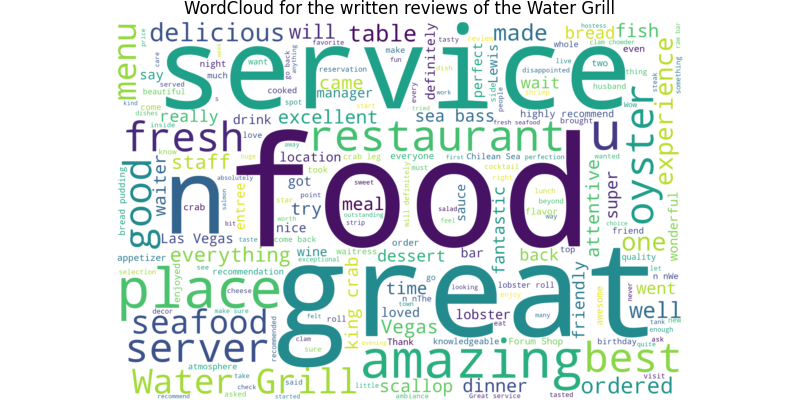

In [48]:
text = WaterGrill_review.toPandas().values
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'white',
    stopwords = STOPWORDS).generate(str(text))
fig = plt.figure(
    figsize = (8, 4),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.title("WordCloud for the written reviews of the Water Grill")
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

%matplot plt

In [50]:
plt.clf()
plt.cla()
plt.close()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…